# Jamie Clark
# CIS 600 Fundamentals of Data and Knowledge Mining
# HW4: Artificial Neural Network and Deep Learning

## Table of Contents
<ul>
<li><a href="#Exec_Summ">Exectuive Summary</a></li>
<li><a href="#Intro">Introduction</a></li>
<li><a href="#Data_Prep">Data Preparation</a></li>
<li><a href="#Scaling">Scaling</a></li>
    <li><a href="#Zero">Zero Hidden Layers</a></li>
<li><a href="#One">One Hidden Layer</a></li>
    <li><a href="#Two">Two Hidden Layers</a></li>
    <li><a href="#DT">Decision Tree</a></li>
    <li><a href="#Compare">Comparison</a></li>
    <li><a href="#Predict">Predictions</a></li>
    <li><a href="#Conclusion">Conclusion</a></li>
</ul>

<a id='Exec_Summ'></a>
## Executive Summary 

In this homework assignment, I am going to use multiple artificial nerual networks and deep learning with different architectures to build a disease diagnosis model. It is a binary classification problem to predict whether or not a patient has a certain unspecified disease.

<a id='Intro'></a>
## Introduction 

I was given a dataset where we will look to determine whether or not a patient has a certain unspecified disease through multiple learning algorithms. In this report, we will prepare the data for each learning algorithm, build, tune and evaluate each different algorithm and end with predicting the results on a second dataset of patients.

Let's begin the report by running the different tools that we will need in order to complete the analysis and loading the datasets. We will use pandas and numpy for the bulk of our data analysis tools. We will use sklearn and its functions for machine learning algorithms. Matplotlib and Seaborn will be used to generate any graphs that are necessary for visualizations. We will establish our random seed at 66 so that results can be replicated throughout the report for verification. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from sklearn import metrics
# from sklearn import tree #should help visualize tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sb
%matplotlib inline
np.random.seed(66)

In [3]:
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree #help visualize tree
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [5]:
train = pd.read_csv('Disease Prediction Training.csv')
test = pd.read_csv('Disease Prediction Testing.csv')

<a id='Data_Prep'></a>
## Data Preperation 

My initial review of the data showed that we have no null values to take care of, which is great for our learning algorithms. However, there are some outlier data points that need to be addressed in the High and Low Blood Pressure columns. We will first take care of those and then move on towards getting all of the data into numerical values.

For ease of our code, we will first remove the spaces in the High and Low Blood Pressure titles. 

In [6]:
train.rename(columns={'High Blood Pressure':'HighBloodPressure',
                    'Low Blood Pressure':'LowBloodPressure'},
           inplace=True)

Now let's look at the graph so we can get an understanding of where we'll need to adjust these values.

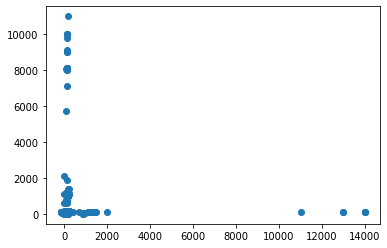

In [7]:
#train.plt.scatter(x='HighBloodPressure', y='LowBloodPressure')
plt.scatter(train.HighBloodPressure, train.LowBloodPressure);

Looking at this graph, many values are way outside of livable blood pressure values. We will remove any values that are above 250 for both High and Low blood pressure. In total, this will remove 27 High Blood Pressure rows and 659 Low Blood Pressure rows, roughly 1% of our data. 

In [8]:
train = train[train.HighBloodPressure <= 250]
train = train[train.LowBloodPressure <= 250]

Let's verify that everything looks good with our graph now.

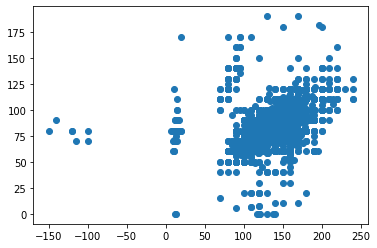

In [9]:
plt.scatter(train.HighBloodPressure, train.LowBloodPressure);

We have fixed our too high values, but now values that are too low have appeared for High Blood Pressure. Searching for these values we find that there are approximately 146 of them, which we will also now delete. 

In [10]:
train = train[train.HighBloodPressure >= 75]

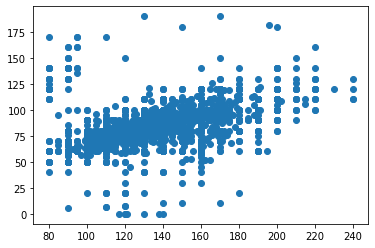

In [11]:
plt.scatter(train.HighBloodPressure, train.LowBloodPressure);

Now that our numbers look good, let's address our categorical data. We will be changing 'Female' to 0 and 'Male' to 1. We will also be changing 'Normal' to 0, 'High' to 1 and 'Too High' to 2.

In [12]:
#female set to 0 and male set to 1
train = train.replace('female',0)
train = train.replace('male', 1)
#normal 0, high 1, too high 2
train = train.replace('normal',0)
train = train.replace('too high',2)
train = train.replace('high',1)

In [13]:
train.describe()

,Age,Gender,Height,Weight,HighBloodPressure,LowBloodPressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease
count,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000,48168.000000
mean,52.845354,0.348759,164.370163,74.108687,126.656619,81.351665,0.365076,0.225938,0.088129,0.054061,0.802981,0.495495
std,6.763391,0.476582,8.196676,14.262047,16.732572,9.852969,0.678819,0.571939,0.283485,0.226140,0.397751,0.499985
min,29.000000,0.000000,55.000000,11.000000,80.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,0.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,1.000000,207.000000,200.000000,240.000000,190.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000


Now that we have a clean dataset, lets create some subsets of this dataset that we can use for training and testing. First we will create a copy of our Train dataset, which will drop the 'Disease' column. We will create another dataframe that will hold the values of the 'Disease' column. Next we will split the data with 70% training and 30% testing. That will have prepared us to enter our algorithm building phase. 

In [14]:
X = train.copy()
X = X.drop(columns=['Disease'])
y = train.Disease

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

<a id='Scaling'></a>
## Scaling

Now that we have clean data, let's scale the values so that our modeling works as intended. 

In [15]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


Let's create a model with zero hidden layers

<a id='Zero'></a>
## Zero Hidden Layers

Let's make our network with zero hidden layers, just our input and output. From reading, a good rule was to have the input be the number of features in the data. Since we have 11 features, we will start with 11. And since we're classifying, we will only have a single node for the output. 

We will try three different types of activation functions to see which produces the best accuracy when fit with 10 epochs and 128 batch size. The epochs were choosen to give a decent amount of repititions, but not take too long in processing. 

In [16]:
model_sig = Sequential()
model_sig.add(Dense(11, activation='sigmoid', input_shape=(11, )))
model_sig.add(Dense(1, activation='sigmoid'))

model_tanh = Sequential()
model_tanh.add(Dense(11, activation='tanh', input_shape=(11, )))
model_tanh.add(Dense(1, activation='tanh'))

model_relu = Sequential()
model_relu.add(Dense(11, activation='relu', input_shape=(11, )))
model_relu.add(Dense(1, activation='relu'))

model_sig.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_tanh.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_relu.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
activation_acc = []
#global variable to control verbose outputs
verbs = 0

In [25]:
check = model_sig.evaluate(X_train, y_train, verbose=verbs)
activation_acc.append(check[1])

In [26]:
check = model_tanh.evaluate(X_train, y_train, verbose=verbs,)
activation_acc.append(check[1])

In [27]:
check = model_relu.evaluate(X_train, y_train, verbose=verbs,)
activation_acc.append(check[1])

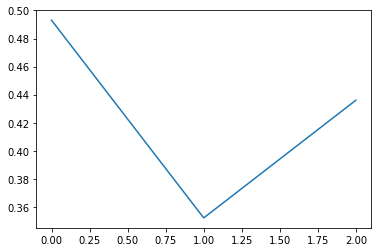

In [28]:
plt.plot(activation_acc);

Based off these values, we're going to stick with the Sigmued activation.

Now we will check our compilation parameters. We will stick with the binary_crossentropy loss since we have a binary classification problem on our hands. We will check for improvements to the optimizer. We will loop through and check the accuracy for each optimizer. We will select the highest accuracy optimizer.


In [30]:
loss_param = []
optimizer_param = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
for x in optimizer_param:
    model_sig.compile(loss='binary_crossentropy', optimizer=x, metrics=['accuracy'])
    hold = model_sig.evaluate(X_train, y_train, verbose=verbs,)
    #print(hold)
    loss_param.append(hold[1])

Let's plot the results.

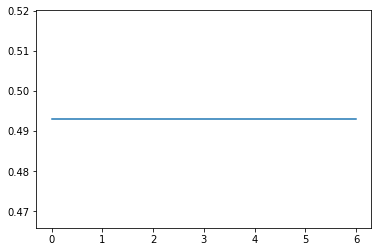

In [31]:
plt.plot(loss_param)

It looks like the optimizer does not matter in this case, as they all produced the same results. So let's create our final model for zero hidden layers and fit it. 

In [32]:
model_zero = Sequential()
model_zero.add(Dense(11, activation='sigmoid', input_shape=(11, )))
model_zero.add(Dense(1, activation='sigmoid'))

In [33]:
model_zero.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
model_zero.fit(X_train, y_train, epochs=10, batch_size=128, verbose=verbs);

Now let's predict the results that we will get.

In [34]:
y_pred_zero = model_zero.predict(X_test) >= 0.5
confusion_matrix(y_test, y_pred_zero)

array([[5420, 1831],
       [2248, 4952]], dtype=int64)

In [35]:
print(classification_report(y_test, y_pred_zero))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      7251
           1       0.73      0.69      0.71      7200

    accuracy                           0.72     14451
   macro avg       0.72      0.72      0.72     14451
weighted avg       0.72      0.72      0.72     14451



Not all that great results. Let's see if adding a hidden layer will help. 

<a id='One'></a>
## One Hidden Layer

First we will attempt to find a good number of nuerons for the hidden layer. Afterwards we will see what activation function will provide the best results, followed by the optimizer parameter to be selected. 

We will start our tuning of nuerons by using the sigmoid activation, since it provided the best results in the zero hidden layers predictions. We will search from 1-26 and create an array to hold our values. 

In [36]:
neurons = range(1,26)
acc_param = []

Let's run a loop that will check the accuracy for each neuron count. 

In [37]:
for x in neurons:
    #create the model
    model_sig = Sequential()
    model_sig.add(Dense(11, activation='sigmoid', input_shape=(11, )))
    #neurons changed here
    model_sig.add(Dense(x, activation='sigmoid'))
    model_sig.add(Dense(1, activation='sigmoid'))
    
    #compile results
    model_sig.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    #get basic accuracies
    check = model_sig.evaluate(X_train, y_train, verbose=verbs)
    acc_param.append(check[1])

Now let's plot our info. 

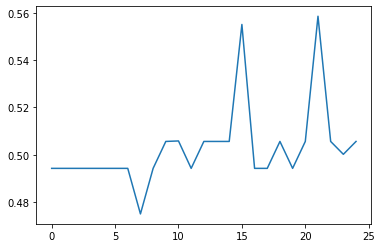

In [38]:
plt.plot(acc_param);

Let's get the index for the max value, since this may change if we modify any of our data. 

In [39]:
oneLayerNeuron = np.argmax(acc_param) + 1

Now let's compare the activation functions. 

In [40]:
model_sig = Sequential()
model_sig.add(Dense(11, activation='sigmoid', input_shape=(11, )))
model_sig.add(Dense(oneLayerNeuron, activation='sigmoid'))
model_sig.add(Dense(1, activation='sigmoid'))

model_tanh = Sequential()
model_tanh.add(Dense(11, activation='tanh', input_shape=(11, )))
model_tanh.add(Dense(oneLayerNeuron, activation='tanh'))
model_tanh.add(Dense(1, activation='tanh'))

model_relu = Sequential()
model_relu.add(Dense(11, activation='relu', input_shape=(11, )))
model_relu.add(Dense(oneLayerNeuron, activation='relu'))
model_relu.add(Dense(1, activation='relu'))

model_sig.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_tanh.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_relu.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

activation_acc = []

check = model_sig.evaluate(X_train, y_train, verbose=verbs)
activation_acc.append(check[1])
check = model_tanh.evaluate(X_train, y_train, verbose=verbs,)
activation_acc.append(check[1])
check = model_relu.evaluate(X_train, y_train, verbose=verbs,)
activation_acc.append(check[1])

Now let's plot the results

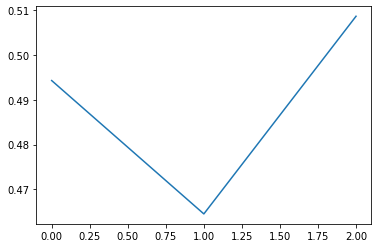

In [41]:
plt.plot(activation_acc);

It looks like relu is the best accuracy for these, so we will use that in our final predictions. Now let's check our optimizers

In [42]:
loss_param = []
optimizer_param = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
for x in optimizer_param:
    model_relu.compile(loss='binary_crossentropy', optimizer=x, metrics=['accuracy'])
    hold = model_relu.evaluate(X_train, y_train, verbose=verbs,)
    #print(hold)
    loss_param.append(hold[1])

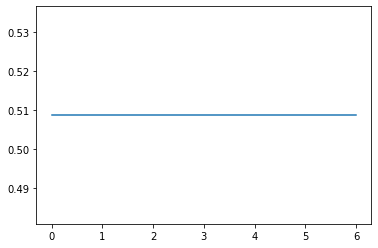

In [43]:
plt.plot(loss_param)

Again, a straight line that shows there is no difference in these loss values. At least for the data we are currently running. 

Let's create the final model we will use. 

In [44]:
model_one = Sequential()
model_one.add(Dense(11, activation='relu', input_shape=(11, )))
model_one.add(Dense(oneLayerNeuron, activation='relu'))
model_one.add(Dense(1, activation='relu'))

model_one.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_one.fit(X_train, y_train, epochs=10, batch_size=128, verbose=verbs);

In [45]:
y_pred_one = model_one.predict(X_test) >= 0.5
confusion_matrix(y_test, y_pred_one)

array([[5389, 1862],
       [2225, 4975]], dtype=int64)

In [46]:
print(classification_report(y_test, y_pred_one))

              precision    recall  f1-score   support

           0       0.71      0.74      0.73      7251
           1       0.73      0.69      0.71      7200

    accuracy                           0.72     14451
   macro avg       0.72      0.72      0.72     14451
weighted avg       0.72      0.72      0.72     14451



This seems to have gotten worse. Perhaps too many layers overly complicating the problem. 

<a id='Two'></a>
## Two Hidden Layers

First we will attempt to find a good number of nuerons for the hidden layer. Afterwards we will see what activation function will provide the best results, followed by the optimizer parameter to be selected. 

We will start our tuning of nuerons by using the relu activation, since it provided the best results in the one hidden layer predictions. Since we noticed a distinct drop after about 15 in the last layer, let's lower our range to only 15. 

In [47]:
neurons = range(1,16)
acc_param = []

In [48]:
for x in neurons:
    #create the model
    model_sig = Sequential()
    model_sig.add(Dense(11, activation='relu', input_shape=(11, )))
    #neurons changed here
    model_sig.add(Dense(oneLayerNeuron, activation='relu'))
    model_sig.add(Dense(x, activation='relu'))
    model_sig.add(Dense(1, activation='relu'))

    #compile results
    model_sig.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

    #get basic accuracies
    check = model_sig.evaluate(X_train, y_train, verbose=verbs)
    acc_param.append(check[1])

Let's plot the results

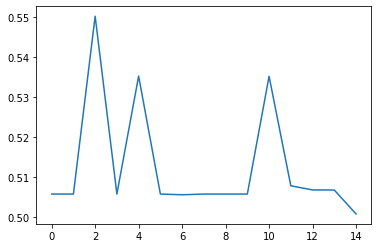

In [49]:
plt.plot(acc_param);

Let's get the index for the max value, since this may change if we modify any of our data. 

In [50]:
twoLayerNeuron = np.argmax(acc_param) + 1

Now let's compare the activation functions. 

In [51]:
model_sig = Sequential()
model_sig.add(Dense(11, activation='sigmoid', input_shape=(11, )))
model_sig.add(Dense(oneLayerNeuron, activation='sigmoid'))
model_sig.add(Dense(twoLayerNeuron, activation='sigmoid'))
model_sig.add(Dense(1, activation='sigmoid'))

model_tanh = Sequential()
model_tanh.add(Dense(11, activation='tanh', input_shape=(11, )))
model_tanh.add(Dense(oneLayerNeuron, activation='tanh'))
model_tanh.add(Dense(twoLayerNeuron, activation='tanh'))
model_tanh.add(Dense(1, activation='tanh'))

model_relu = Sequential()
model_relu.add(Dense(11, activation='relu', input_shape=(11, )))
model_relu.add(Dense(oneLayerNeuron, activation='relu'))
model_relu.add(Dense(twoLayerNeuron, activation='relu'))
model_relu.add(Dense(1, activation='relu'))

model_sig.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_tanh.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_relu.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

activation_acc = []

check = model_sig.evaluate(X_train, y_train, verbose=verbs)
activation_acc.append(check[1])
check = model_tanh.evaluate(X_train, y_train, verbose=verbs,)
activation_acc.append(check[1])
check = model_relu.evaluate(X_train, y_train, verbose=verbs,)
activation_acc.append(check[1])

Now let's plot the results

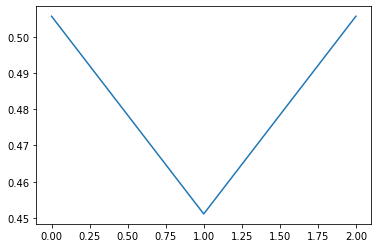

In [52]:
plt.plot(activation_acc);

It looks like relu is the best accuracy for these, so we will use that in our final predictions. Now let's check our optimizers

In [53]:
loss_param = []
optimizer_param = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
for x in optimizer_param:
    model_relu.compile(loss='binary_crossentropy', optimizer=x, metrics=['accuracy'])
    hold = model_relu.evaluate(X_train, y_train, verbose=verbs,)
    #print(hold)
    loss_param.append(hold[1])

[7.62486628328958, 0.5056796073913574]
[7.62486628328958, 0.5056796073913574]
[7.62486628328958, 0.5056796073913574]
[7.62486628328958, 0.5056796073913574]
[7.62486628328958, 0.5056796073913574]
[7.62486628328958, 0.5056796073913574]
[7.62486628328958, 0.5056796073913574]


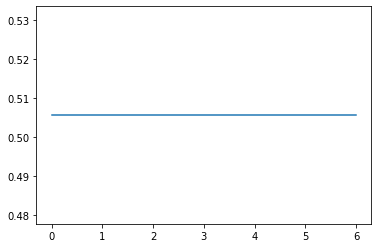

In [54]:
plt.plot(loss_param)

Again, a straight line that shows there is no difference in these loss values. At least for the data we are currently running. 

Let's create the final model we will use. 

In [55]:
model_two = Sequential()
model_two.add(Dense(11, activation='relu', input_shape=(11, )))
model_two.add(Dense(oneLayerNeuron, activation='relu'))
model_two.add(Dense(twoLayerNeuron, activation='relu'))
model_two.add(Dense(1, activation='relu'))

model_two.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model_two.fit(X_train, y_train, epochs=10, batch_size=128, verbose=verbs);

In [56]:
y_pred_two = model_two.predict(X_test) >= 0.5
confusion_matrix(y_test, y_pred_two)

array([[7251,    0],
       [7200,    0]], dtype=int64)

In [57]:
print(classification_report(y_test, y_pred_two))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      7251
           1       0.00      0.00      0.00      7200

    accuracy                           0.50     14451
   macro avg       0.25      0.50      0.33     14451
weighted avg       0.25      0.50      0.34     14451



G:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<a id='DT'></a>
## Decision Tree

Let's see how things look when compared to the Decision Tree algorithm. First we will find the best hyperparameters

In [70]:
#Generating a count that we can use to adjust the ranges 
counter = pd.array(range(1,100))
#creating a dataframe to hold the results
df = pd.DataFrame({'Counts': counter })

#array to hold the values to put into the dataframe
tableCheck = []

#max depth
print("max_depth")
for i in counter:
    clf2 = DecisionTreeClassifier(max_depth=i)
    clf2.fit(X_train, y_train)
    y_pred = clf2.predict(X_test)
    y_pred = np.where(y_pred==True, 1, 0)
    tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
#     #debug code
#     if i % 10 == 0: 
#         print(i)

df['Max_Depth'] = tableCheck
tableCheck.clear()

#max_leaf_nodes
print("max_leaf_nodes")
for i in counter:
    if i > 1:
        clf2 = DecisionTreeClassifier(max_leaf_nodes=i)
        clf2.fit(X_train, y_train)
        y_pred = clf2.predict(X_test)
        y_pred = np.where(y_pred==True, 1, 0)
        tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
    else:
        tableCheck.append(np.NaN)
#     #debug code
#     if i % 10 == 0:
#         print(i)
        
df['max_leaf_nodes'] = tableCheck
tableCheck.clear()

#min_samples_leaf
print("min_samples_leaf")
for i in counter:
    clf2 = DecisionTreeClassifier(min_samples_leaf=i)
    clf2.fit(X_train, y_train)
    y_pred = clf2.predict(X_test)
    y_pred = np.where(y_pred==True, 1, 0)
    tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
    #debug code
#     if i % 10 == 0:
#         print(i)
        
df['min_samples_leaf'] = tableCheck
tableCheck.clear()

#min_samples_split
print("min_samples_split")
for i in counter:
    if i > 1:
        clf2 = DecisionTreeClassifier(min_samples_split=i)
        clf2.fit(X_train, y_train)
        y_pred = clf2.predict(X_test)
        y_pred = np.where(y_pred==True, 1, 0)
        tableCheck.append(round(metrics.accuracy_score(y_test, y_pred)*100,2))
    else:
        tableCheck.append(np.NaN)
    #debug code
#     if i % 10 == 0:
#         print(i)
        
df['min_samples_split'] = tableCheck
tableCheck.clear()

max_depth
max_leaf_nodes
min_samples_leaf
min_samples_split


Let's graph what the results look like

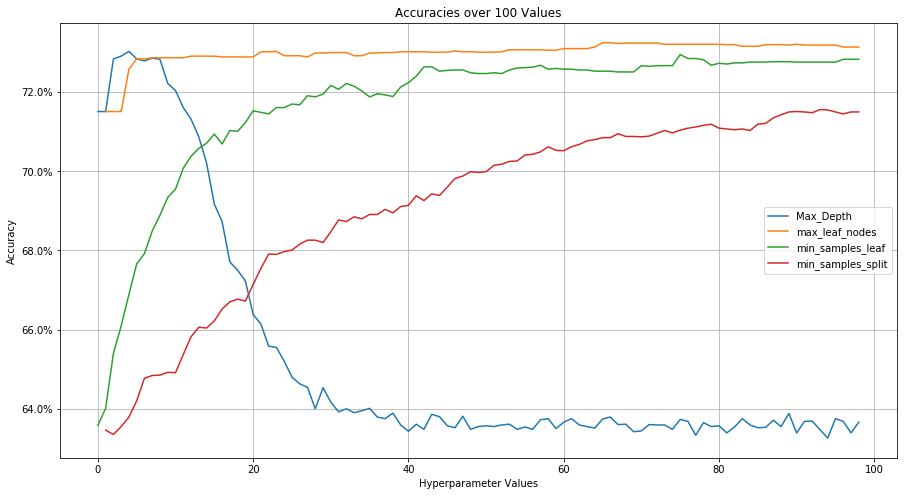

In [71]:
#we don't need the Counts column, only used to set correct length of dataframe
df = df.drop(columns='Counts')

g = df.plot.line(figsize=(15,8),title="Accuracies over 100 Values", grid=True);
g.set_xlabel("Hyperparameter Values")
g.set_ylabel("Accuracy")
g.yaxis.set_major_formatter(mtick.PercentFormatter())

Now let's pull out the top 3 values that we should use in our GridSearchCV

In [72]:
maxDepth = df['Max_Depth'].nlargest(3).index.values.tolist()
maxLeafNodes = df['max_leaf_nodes'].nlargest(3).index.values.tolist()
minSamplesLeaf = df['min_samples_leaf'].nlargest(3).index.values.tolist()
minSamplesSplit = df['min_samples_split'].nlargest(3).index.values.tolist()

#since the index are 0 based, we need to add 1 to get the proper values used
maxDepth = np.array(maxDepth) + 1
maxLeafNodes = np.array(maxLeafNodes) + 1
minSamplesLeaf = np.array(minSamplesLeaf) + 1
minSamplesSplit = np.array(minSamplesSplit) + 1

Now let's run the GridSearchCV

In [73]:
clf = DecisionTreeClassifier()
param_grid = {'criterion': ['gini', 'entropy'],
  'min_samples_split': minSamplesSplit,
  'max_depth': maxDepth,
  'min_samples_leaf': minSamplesLeaf,
  'max_leaf_nodes': maxLeafNodes}
grid = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1,verbose=0)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

Our best hyperparameter values.

In [74]:
print(f"Accuracy: {round(grid.best_score_*100, 2)}%")
for key, value in grid.best_params_.items():
  print(f"Hyperparameter: {key}; Value: {value}")

Accuracy: 73.21%
Hyperparameter: criterion; Value: gini
Hyperparameter: max_depth; Value: 8
Hyperparameter: max_leaf_nodes; Value: 66
Hyperparameter: min_samples_leaf; Value: 77
Hyperparameter: min_samples_split; Value: 94


Now let's predict

In [75]:
y_pred = grid.best_estimator_.predict(X_test)
report = classification_report(y_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.7062    0.7898    0.7457      7251
           1     0.7597    0.6690    0.7115      7200

    accuracy                         0.7296     14451
   macro avg     0.7329    0.7294    0.7286     14451
weighted avg     0.7328    0.7296    0.7286     14451



<a id='Compare'></a>
## Comparison

Let's see how this compares to the other supervised learning algorithms that we performed in HW3. The time values do not include time to find the hyperparameters. The hyperparameters also do not take into consideration improvements that I learned over the course of doing the final project, like stopping short for Gradient Boosting. 

| Method | Accuracy | Time | Hyperparameters | 
| --- | --- | --- | -- |
| Gradient Boosting | 73.68% |  265 ms |  criterion=mse, min_samples_split=2, max_depth=11, min_samples_leaf=10, max_leaf_nodes=7, n_estimators=15 |
| Decision Tree | 72.9% | 1 s |  criterion=gini, max_depth=5, max_leaf_nodes=15, min_samples_leaf=18, min_samples_split=19 |
| ANN0 | 72% | 6.3 s | activation=sigmoid, loss=binary_crossentropy, optimizer=SGD, epochs=10, batch_size=128 |
| ANN2 | 72% | 28.5 s | activation=relu, loss=binary_crossentropy, optimizer=SGD, epochs=10, batch_size=128 |
| Random Forest | 71.11% |  478 ms | criterion=gini, max_depth=11, max_leaf_nodes=90, min_samples_leaf=17, min_samples_split=74, n_estimators=95 |
| Guassian Naive Bayes | 71.09% | 50 ms | None |
| ANN1 | 64% | 11.4 s | neurons=13, activation=relu, loss=binary_crossentropy, optimizer=Adam, epochs=10, batch_size=128 |
| K Nearest Neighbor | 59.01% | 1.5 s | leaf_size=9, n_neighbors=99 |




<a id='Predict'></a>
## Predictions

Now we will run our tuned algorithms to predict the classifier. We will do it for each algorithm, combine them into a dataframe and export that dataframe into a csv. 

Let's do some slight data cleaning first by changing the column names again. Then we will modify the categorical into numerical data just like we did for the training data.

In [76]:
test = pd.read_csv('Disease Prediction Testing.csv')

In [77]:
test.rename(columns={'High Blood Pressure':'HighBloodPressure',
                    'Low Blood Pressure':'LowBloodPressure'},
           inplace=True)

In [78]:
#female set to 0 and male set to 1
test = test.replace('female',0)
test = test.replace('male', 1)
#normal 0, high 1, too high 2
test = test.replace('normal',0)
test = test.replace('too high',2)
test = test.replace('high',1)

Now we need to drop the ID columns so that it matches the column length of our previous data. We will move the ID column to our final dataframe. 

In [79]:
final = pd.DataFrame()
final['ID'] = test['ID']
test = test.drop(columns=['ID'])

Now let's run all the predictions on our test dataframe and store the results.

In [80]:
DTResults = grid.best_estimator_.predict(test)
ANN0Results = model_zero.predict(test)
ANN1Results = model_one.predict(test)
ANN2Results = model_two.predict(test)

Finally, we move the results into our final dataframe and export it to csv for submission. 

In [81]:
final['DT'] = DTResults
final['ANN0'] = ANN0Results
final['ANN1'] = ANN1Results
final['ANN2'] = ANN2Results
final.to_csv('Prediction_Results.csv', index=False)

<a id='Conclusion'></a>
## Conclusion

We have created several neural networks to predict results and compared them to previous algorithms. Tuning the hyperparameters were more of a challenge with this algorithm compared to otheres because I failed to get GridSearchCV to function as intended. I also did not develop an automated way to find locate the best parameters like I did for other features. I would like to find out why the loss functions showed no change on any of my models. 